In [30]:
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
from operator import add
from scipy.stats import norm
import math

### ENUM DEFINITIONS ###

In [2]:
class OptionType(Enum):
    CALL = 1
    PUT = 2

class OrderType(Enum):
    BUY = 1
    SELL = 2

### CLASS DEFINITIONS ###

In [70]:
#source: https://www.codearmo.com/python-tutorial/options-trading-black-scholes-model
class Utils:
    @staticmethod
    def get_option_price(option_type, spot_price, strike_price, risk_free_rate=0.05, volatility=0.25, time=1):
        
        d1 = (math.log(spot_price / strike_price) + (risk_free_rate + 0.5 * volatility**2) * time) / (volatility * math.sqrt(time))
        d2 = d1 - volatility * math.sqrt(time)

        if option_type == OptionType.CALL:
            option_price = spot_price * norm.cdf(d1) - strike_price * math.exp(-risk_free_rate * time) * norm.cdf(d2)
        elif option_type == OptionType.PUT:
            option_price = strike_price * math.exp(-risk_free_rate * time) * norm.cdf(-d2) - spot_price * norm.cdf(-d1)
        else:
            raise Exception("Unknown option type")

        return option_price
        
    @staticmethod
    def norm_cdf(x):
        return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

In [46]:
class Option:
    def __init__(self, option_type, order_type, strike_price, spot_price, option_price=False):
        self.option_type = option_type
        self.order_type = order_type
        self.strike_price = strike_price
        self.option_price = option_price if option_price else  Utils.get_option_price(option_type, spot_price, strike_price)

    def __str__(self) -> str:
        name = ""
        if self.order_type == OrderType.BUY:
            name += "BUY"
        elif self.order_type == OrderType.SELL:
            name += "SELL"
        name += " "
        if self.option_type == OptionType.CALL:
            name += "CALL"
        elif self.option_type == OptionType.PUT:
            name += "PUT"
        
            
        return name
    
    def value(self, point): 
        result = 0
        difference = point - self.strike_price
        
        if self.option_type == OptionType.CALL:
            if self.order_type == OrderType.BUY:
                if point < self.strike_price:
                    result = -self.option_price
                else:
                    result = difference - self.option_price
            elif self.order_type == OrderType.SELL:
                if point < self.strike_price:
                    result = self.option_price
                else: 
                    result = self.option_price - difference
        elif self.option_type == OptionType.PUT:
            if self.order_type == OrderType.BUY:
                if point > self.strike_price:
                    result = -self.option_price
                else:
                    result = -difference - self.option_price
            elif self.order_type == OrderType.SELL:
                if point > self.strike_price:
                    result = self.option_price
                else: 
                    result = difference + self.option_price
        
        return result

In [47]:
class Stock:
    def __init__(self, price):
        self.price = price

    def __str__(self) -> str:
        return "STOCK"
    
    def value(self, point):
        return point

In [48]:
class Portfolio:
    def __init__(self, name, stocks, options):
        self.name = name
        self.stocks = stocks
        self.options = options

    def visualize(self, start, end, step, seperate = False):
        x = np.arange(start, end, step)
        y = np.zeros(len(x))
        strike_prices = [option.strike_price for (option, quantity) in self.options]
        for (stock, quantity) in self.stocks:
            _y = [stock.value(point) * quantity for point in x]
            if seperate:
                plt.plot(x, _y, '#4F4F4F')
            y = list(map(add, y, _y))
        for (option, quantity) in self.options:
            _y = [option.value(point) * quantity for point in x]
            if seperate:
                plt.plot(x, _y, '#4F4F4F')
            y = list(map(add, y, _y))

        for (option, quantity) in self.options:
            plt.legend([str(option) for (option, quantity) in self.options])
        plt.plot(strike_prices, np.zeros(len(strike_prices)), 'ro')
        plt.plot(x, y, 'red')
        plt.grid(True)
        plt.axhline(y=0, color='gray')
        plt.axvline(x=0, color='gray')
        plt.xlabel('Stock Price')
        plt.ylabel('Portfolio Value')
        plt.title(self.name)
        plt.show()

    def add_stock(self, stock, quantity):
        s = Stock(stock.price)  
        self.stocks.append((s, quantity))

    def add_option(self, option, quantity):
        o = Option(option.option_type, option.order_type, option.strike_price, option.option_price)
        self.options.append((o, quantity))

    def __str__(self) -> str:
        return self.name

In [49]:
buycall = Option(OptionType.CALL, OrderType.BUY, 80, 100, 20)
sellcall = Option(OptionType.CALL, OrderType.SELL, 80, 100, 20)
buyput = Option(OptionType.PUT, OrderType.BUY, 80, 100, 20)
sellput = Option(OptionType.PUT, OrderType.SELL, 80, 100, 20)

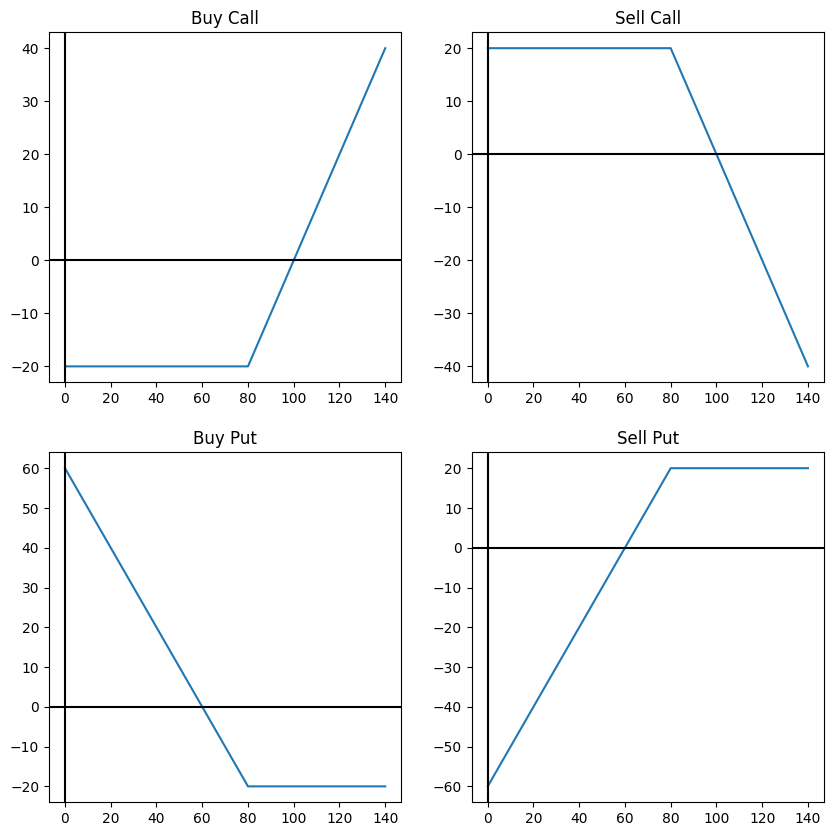

In [50]:
x = np.arange(0., 150., 10)
fig, axis = plt.subplots(2, 2, figsize=(10, 10))
axis[0, 0].plot(x, list(map(buycall.value, x)))
axis[0, 0].set_title("Buy Call")
axis[0, 0].axhline(0, color='black')
axis[0, 0].axvline(0, color='black')

axis[0, 1].plot(x, list(map(sellcall.value, x)))
axis[0, 1].set_title("Sell Call")
axis[0, 1].axhline(0, color='black')
axis[0, 1].axvline(0, color='black')

axis[1, 0].plot(x, list(map(buyput.value, x)))
axis[1, 0].set_title("Buy Put")
axis[1, 0].axhline(0, color='black')
axis[1, 0].axvline(0, color='black')

axis[1, 1].plot(x, list(map(sellput.value, x)))
axis[1, 1].set_title("Sell Put")
axis[1, 1].axhline(0, color='black')
axis[1, 1].axvline(0, color='black')

### TO avoid determine option price every time, we can use black-scholes formula to calculate the option price.
### Firstly lets looks how parameters affect the option price.

[43.195040983358105, 43.10401046357235, 43.01302840166006, 42.92209517803944, 42.83121117396859, 42.74037677152826, 42.64959235360465, 42.5588583038722, 42.4681750067761, 42.377542847515016, 42.286962212023425, 42.19643348695429, 42.105957059661186, 42.01553331818082, 41.92516265121523, 41.83484544811401, 41.74458209885642, 41.6543729940336, 41.564218524830544, 41.47411908300816, 41.384075060885216, 41.2940868513203, 41.204154847693644, 41.11427944388908, 41.0244610342757, 40.93470001368981, 40.84499677741655, 40.75535172117158, 40.66576524108293, 40.57623773367252, 40.48676959583778, 40.39736122483339, 40.308013018252794, 40.21872537400968, 40.12949869031974, 40.04033336568205, 39.951229798860645, 39.86218838886603, 39.773209534936754, 39.68429363652081, 39.59544109325718, 39.50665230495734, 39.417927671586725, 39.32926759324623, 39.24067247015374, 39.15214270262556, 39.06367869105796, 38.97528083590871, 38.88694953767856, 38.79868519689276, 38.71048821408272, 38.62235898976742, 38.53

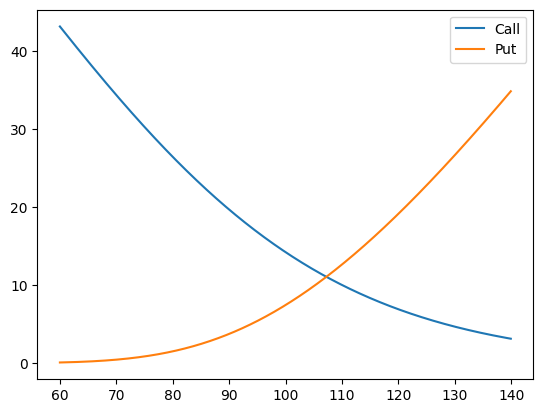

In [73]:
strike_prices = np.arange(60,140,0.1)
calls_by_price = [Utils.get_option_price(OptionType.CALL, spot_price=100, strike_price=strike_price, time=1, volatility=0.3, risk_free_rate=0.05) for strike_price in strike_prices]
puts_by_price = [Utils.get_option_price(OptionType.PUT, spot_price=100, strike_price=strike_price) for strike_price in strike_prices]
print(calls_by_price)
plt.plot(strike_prices, calls_by_price, label="Call")
plt.plot(strike_prices, puts_by_price, label="Put")
plt.legend()
plt.show()

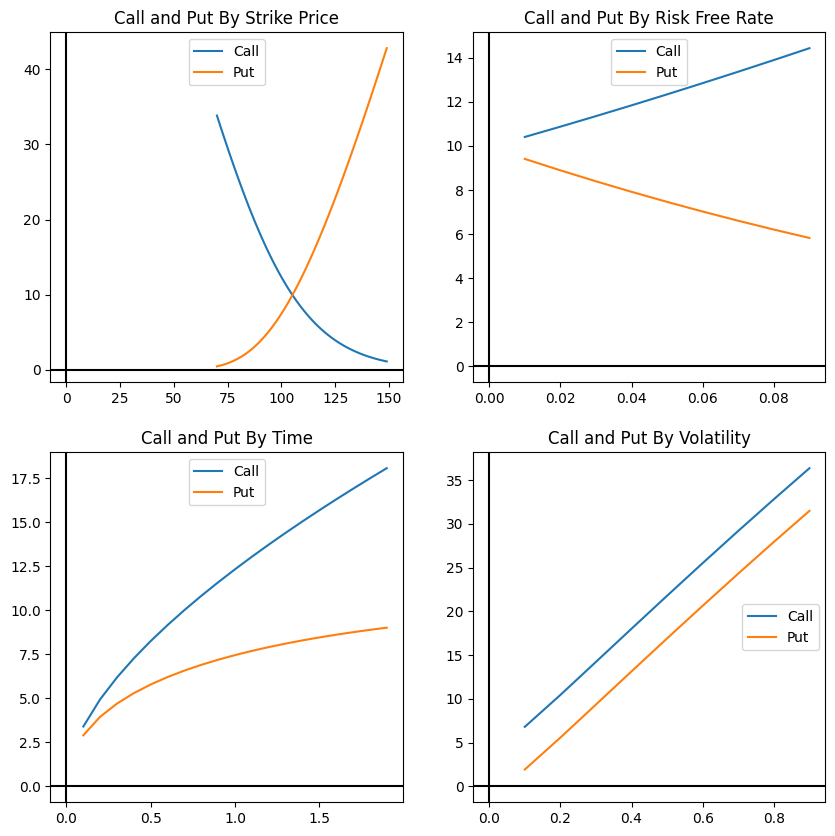

In [77]:
fig, axis = plt.subplots(2, 2, figsize=(10, 10))

strike_prices = np.arange(70., 150., 1)
calls_by_price = [Utils.get_option_price(OptionType.CALL, 100, strike_price) for strike_price in strike_prices]
puts_by_price = [Utils.get_option_price(OptionType.PUT, 100, strike_price) for strike_price in strike_prices]
axis[0, 0].plot(strike_prices, calls_by_price)
axis[0, 0].plot(strike_prices, puts_by_price)
axis[0, 0].set_title("Call and Put By Strike Price")
axis[0, 0].axhline(0, color='black')
axis[0, 0].axvline(0, color='black')
axis[0, 0].legend(['Call', 'Put'])


risk_free_rates = np.arange(0.01, 0.1, 0.01)
calls_by_strike = [Utils.get_option_price(OptionType.CALL, 100, 100, risk_free_rate=risk_free_rate) for risk_free_rate in risk_free_rates]
puts_by_strike = [Utils.get_option_price(OptionType.PUT, 100, 100, risk_free_rate=risk_free_rate) for risk_free_rate in risk_free_rates]
axis[0, 1].plot(risk_free_rates, calls_by_strike)
axis[0, 1].plot(risk_free_rates, puts_by_strike)
axis[0, 1].set_title("Call and Put By Risk Free Rate")
axis[0, 1].axhline(0, color='black')
axis[0, 1].axvline(0, color='black')
axis[0, 1].legend(['Call', 'Put'])


times = np.arange(0.1, 2, 0.1)
calls_by_time = [Utils.get_option_price(OptionType.CALL, 100, 100, time=time) for time in times]
puts_by_time = [Utils.get_option_price(OptionType.PUT, 100, 100, time=time) for time in times]

axis[1, 0].plot(times, calls_by_time)
axis[1, 0].plot(times, puts_by_time)
axis[1, 0].set_title("Call and Put By Time")
axis[1, 0].axhline(0, color='black')
axis[1, 0].axvline(0, color='black')
axis[1, 0].legend(['Call', 'Put'])


volatilities = np.arange(0.1, 1, 0.1)
calls_by_volatility = [Utils.get_option_price(OptionType.CALL, 100, 100, volatility=volatility) for volatility in volatilities]
puts_by_volatility = [Utils.get_option_price(OptionType.PUT, 100, 100, volatility=volatility) for volatility in volatilities]
axis[1, 1].plot(volatilities, calls_by_volatility)
axis[1, 1].plot(volatilities, puts_by_volatility)
axis[1, 1].set_title("Call and Put By Volatility")
axis[1, 1].axhline(0, color='black')
axis[1, 1].axvline(0, color='black')
axis[1, 1].legend(['Call', 'Put'])

plt.show()




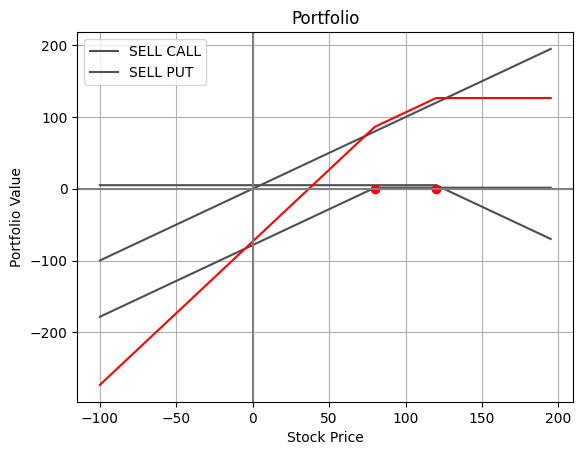

In [52]:
portfolio = Portfolio("Portfolio", [(Stock(100), 1)], [(Option(OptionType.CALL, OrderType.SELL, 120, 100), 1), (Option(OptionType.PUT, OrderType.SELL, 80, 100), 1)])
portfolio.visualize(-100, 200, 5, True)

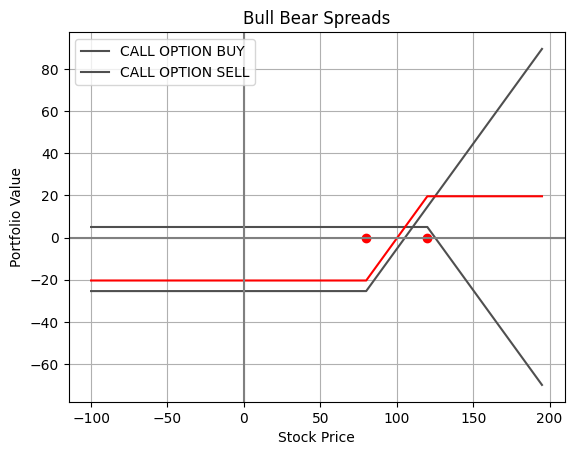

In [36]:
bull_bear_spreads = Portfolio("Bull Bear Spreads", [], [(Option(OptionType.CALL, OrderType.BUY, 80, 100), 1), (Option(OptionType.CALL, OrderType.SELL, 120, 100), 1)])
bull_bear_spreads.visualize(-100, 200, 5, True)

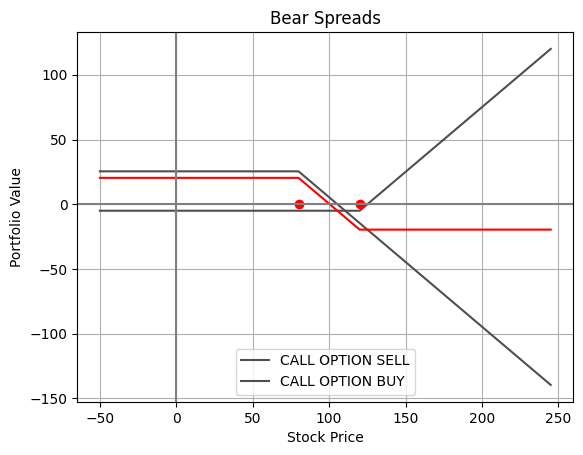

In [37]:
bear_spreads = Portfolio("Bear Spreads", [], [(Option(OptionType.CALL, OrderType.SELL, 80, 100), 1), (Option(OptionType.CALL, OrderType.BUY, 120, 100), 1)])
bear_spreads.visualize(-50, 250, 5, True)

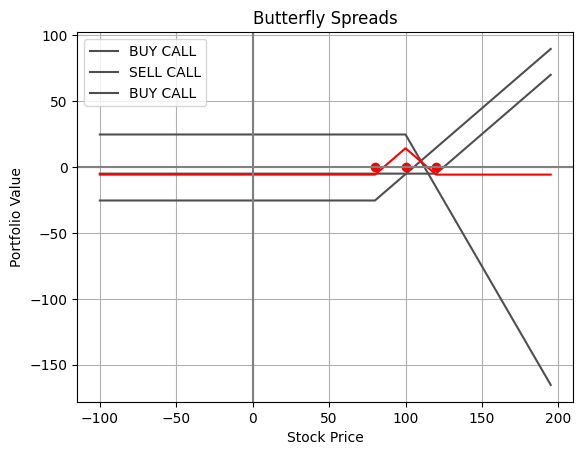

In [53]:
butterfly_spreads = Portfolio("Butterfly Spreads", [], [(Option(OptionType.CALL, OrderType.BUY, 80, 100), 1), (Option(OptionType.CALL, OrderType.SELL, 100, 100), 2), (Option(OptionType.CALL, OrderType.BUY, 120, 100), 1)])
butterfly_spreads.visualize(-100, 200, 5, True)

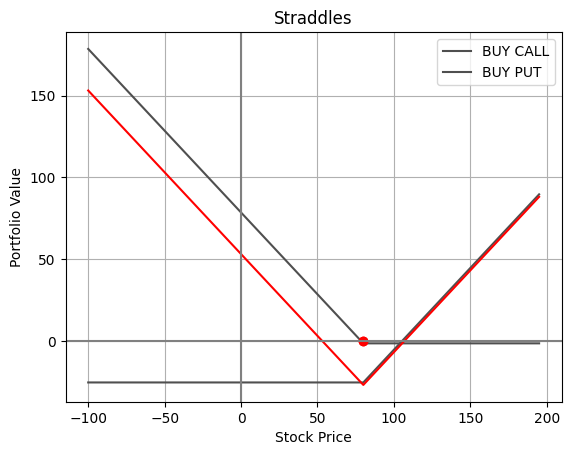

In [54]:
straddles = Portfolio("Straddles", [], [(Option(OptionType.CALL, OrderType.BUY, 80, 100), 1), (Option(OptionType.PUT, OrderType.BUY, 80, 100), 1)])
straddles.visualize(-100, 200, 5, True)

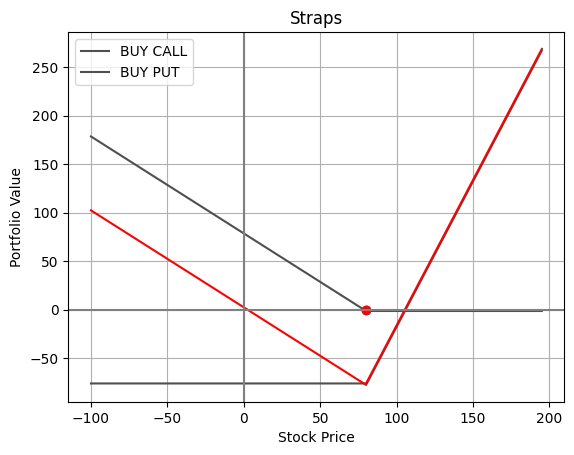

In [55]:
strap = Portfolio("Straps", [], [(Option(OptionType.CALL, OrderType.BUY, 80, 100), 3), (Option(OptionType.PUT, OrderType.BUY, 80, 100), 1)])
strap.visualize(-100, 200, 5, True)


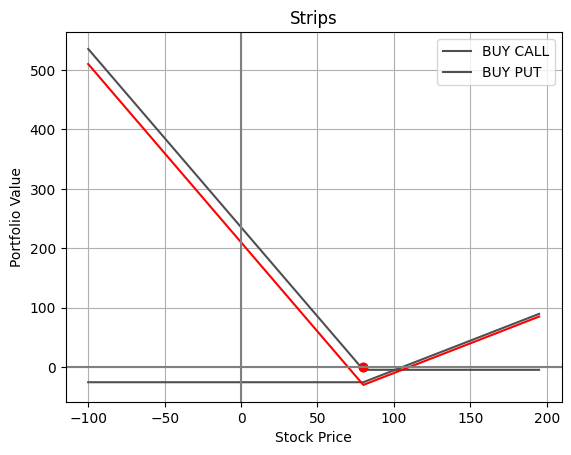

In [56]:
strip = Portfolio("Strips", [], [(Option(OptionType.CALL, OrderType.BUY, 80, 100), 1), (Option(OptionType.PUT, OrderType.BUY, 80, 100), 3)])
strip.visualize(-100, 200, 5, True)

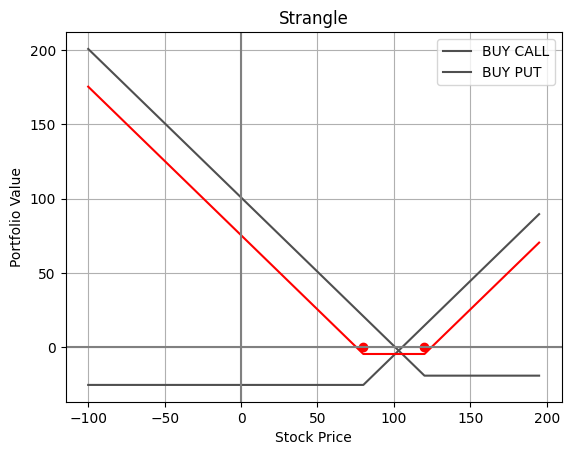

In [57]:
strangle = Portfolio("Strangle", [], [(Option(OptionType.CALL, OrderType.BUY, 80, 100), 1), (Option(OptionType.PUT, OrderType.BUY, 120, 100), 1)])
strangle.visualize(-100, 200, 5, True)

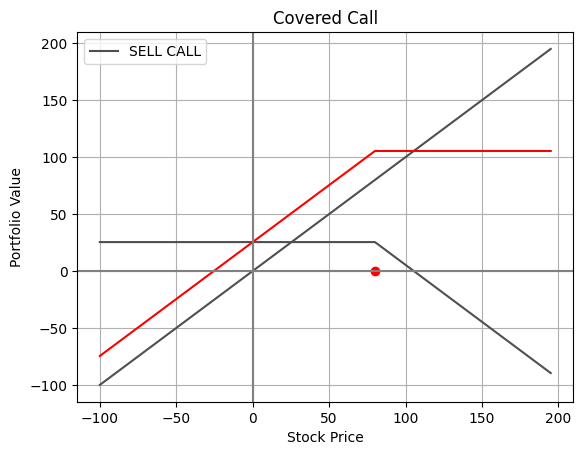

In [58]:
covered_call = Portfolio("Covered Call", [(Stock(100), 1)], [(Option(OptionType.CALL, OrderType.SELL, 80, 100), 1)])
covered_call.visualize(-100, 200, 5, True)